In [1]:
import spacy 
import re 
import pandas as pd
from spacy.lang.en import English
from collections import Counter
from itertools import chain
import ahocorasick
import ast
from analyze_m_data import get_occupations_list_en, get_occupations_list
from spacy.lang.de import German
from spacy.lang.it import Italian
from spacy.lang.es import Spanish 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from operator import itemgetter

In [2]:
def stem_titles(titles):
  from nltk.stem import SnowballStemmer 
  stemmer = SnowballStemmer("spanish") # Choose a language
  stems = []
  for title in titles:
     stem = stemmer.stem(title)
     stems.append(stem)
  return stems
es_occ_titles = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/es_occ_list_from_en.csv', encoding='utf-8')
es_occ_list = es_occ_titles['occupations'].to_list()
es_occ_list = [x for x in es_occ_list if pd.notnull(x)]
stems = stem_titles(es_occ_list)
print(stems[:10])

['abstractor', 'contabl', 'acrobat', 'actor', 'actriz', 'actuari', 'acupresor', 'acupuntor', 'direccion', 'adjud']


In [6]:
def get_occupations(df):
    new_df = df
    # print(unique_gender_counts)
    # number of biographies that returned no intro 
    print("num intros unavailable")
    print((new_df['intro'] == 'No intro available').sum())
    # remove biographies with no intro 
    new_df = new_df[new_df.intro != 'No intro available']
    print(new_df.shape[0])
    small_df = new_df.copy()
    # lowercase intro strings
    small_df['intro'] = small_df['intro'].str.casefold()
    small_df['title'] = small_df['title'].str.casefold()
    # small_df['first_sentence'] = small_df['first_sentence'].str.casefold()
    # the lists in the occupations column were not actual lists but rather string literals
    # this code converts them back into lists  
    # small_df['occupations'] = small_df['occupations'].apply(ast.literal_eval)

    # get a set of occupation words 
    full_unique_occupations = set(stem_titles(es_occ_list))
    # full_unique_occupations = get_occupations_list('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/de_occ_titles.csv', gender)
    # full_unique_occupations = get_occupations_list_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/it_occ_list_full.csv')
    # full_unique_occupations = get_occupations_list_en('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/es_occ_list_unique.csv')
    small_df['intro'] = small_df['intro'].astype(str)
    small_df['title'] = small_df['title'].astype(str)
    
    # want to find overlapping terms in the intros column and the wikidata occupation words set 
    automaton = ahocorasick.Automaton()
    for id, term in enumerate(full_unique_occupations):
        automaton.add_word(term, (term))
    automaton.remove_word('-')
    automaton.make_automaton()
    def find_terms_en(text):
        return list(term for _, term in automaton.iter(text))
    def find_terms_de(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches
    def find_terms_stems1(text):
      matching_tokens = []
      substrings = list(full_unique_occupations)
      tokens = text.split()
      for token in tokens:
        if any(sub in token for sub in substrings):
          matching_tokens.append(token)
      return matching_tokens
    
    def find_terms_stems(text):
      # ner = spacy.load('en_core_web_sm') 
      # ner = spacy.load('de_core_news_sm')
    #   ner = spacy.load('it_core_news_sm') 
      ner = spacy.load('es_core_news_sm')
      doc = ner(text) 
      occupational_titles = list(full_unique_occupations)
      matched_occupations = []
      for ent in doc: 
        if any(sub in ent.text.casefold() for sub in occupational_titles):
          if not ent.ent_type_:
              # matched_occupations.append(ent.text)
              matched_occupations.append({ent.text: ent.morph.get("Gender")})
        # print(ent.text, ent.pos_, ent.dep_)
          # print(ent,ent.morph.get("Gender"))
      return (matched_occupations)
    
    # small_df['overlapping_occupations'] = small_df['intro'].apply(find_terms_stems)
    # small_df['overlapping_occupations_sentence1'] = small_df['first_sentence'].apply(find_terms_stems)
    # want to see if male occupation names show up in title field as last names 
    # small_df['occupation_in_last_name'] = small_df['title'].apply(find_terms_stems)
    small_df['overlapping_occupations_sentence1'] = small_df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    occ_counts_counter = Counter(
    key
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for key in d.keys()
    )

    occ_gender_counts_counter = Counter(
    value
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for values in d.values()
    for value in values
    )
   
    # overlapping_occ_counts = Counter(chain.from_iterable([small_df['overlapping_occupations_sentence1'].keys()]))
    # print(small_df[['wikidata_code','intro', 'overlapping_occupations']].head(20))
    print(occ_counts_counter)
    print(occ_gender_counts_counter)
    smaller_df = small_df[small_df['overlapping_occupations_sentence1'].map(len)>0]
    # smaller_df = smaller_df[smaller_df['overlapping_occupations'].map(len)>0]

    print("length of dataset:")
    print(small_df.shape[0])
    print("first sentences with occ title found:", smaller_df.shape[0])
    return occ_counts_counter
    

In [7]:
es_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/es_female_occ_2.csv', encoding='utf-8')
female_occ_counts = get_occupations(es_female_df)

num intros unavailable
0
8801
Counter({'actriz': 2036, 'escritora': 815, 'deportista': 709, 'cantante': 576, 'periodista': 573, 'modelo': 466, 'profesora': 422, 'presentadora': 364, 'artista': 336, 'directora': 294, 'poeta': 265, 'abogada': 261, 'investigadora': 236, 'activista': 223, 'compositora': 187, 'bailarina': 181, 'pintora': 163, 'historiadora': 161, 'mujer': 145, 'empresaria': 141, 'para': 140, 'productora': 133, 'guionista': 127, 'locutora': 126, 'poetisa': 121, 'especialista': 117, 'hija': 111, 'conductora': 106, 'esposa': 100, 'trayectoria': 95, 'maestra': 94, 'principalmente': 91, 'artísticamente': 90, 'traductora': 89, 'educadora': 89, 'parte': 88, 'dramaturga': 86, 'ensayista': 85, 'mujeres': 83, 'diseñadora': 79, 'autora': 78, 'arquitecta': 77, 'escultora': 72, 'editora': 69, 'presidente': 69, 'futbolista': 58, 'narradora': 58, 'considerada': 57, 'sido': 56, 'economista': 55, 'reina': 52, 'doctora': 52, 'ilustradora': 51, 'participación': 51, 'internacional': 50, 'ingen

In [29]:
es_male_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/es_male_occ_2.csv', encoding='utf-8')
male_occ_counts = get_occupations(es_male_df)

num intros unavailable
0
8781
Counter({'futbolista': 730, 'escritor': 644, 'abogado': 552, 'periodista': 514, 'actor': 427, 'profesor': 345, 'exfutbolista': 320, 'director': 316, 'poeta': 315, 'deportista': 260, 'empresario': 246, 'compositor': 240, 'historiador': 236, 'pintor': 219, 'ingeniero': 204, 'cantante': 154, 'participó': 145, 'productor': 132, 'arquitecto': 125, 'entrenador': 122, 'presidente': 119, 'guionista': 114, 'investigador': 112, 'economista': 108, 'escultor': 93, 'para': 91, 'autor': 90, 'universitario': 89, 'hijo': 81, 'dramaturgo': 81, 'ensayista': 81, 'artista': 80, 'presentador': 78, 'parte': 63, 'locutor': 61, 'editor': 59, 'deportivo': 58, 'maestro': 57, 'funcionario': 54, 'especialista': 54, 'guitarrista': 53, 'trayectoria': 52, 'historia': 49, 'dibujante': 49, 'humorista': 48, 'traductor': 47, 'centrocampista': 46, 'literario': 45, 'presidencia': 43, 'sindicalista': 42, 'sido': 41, 'considerado': 41, 'varios': 40, 'activista': 39, 'ilustrador': 39, 'hermano':

In [7]:
def get_occ_gender_counts(df):
    result = {}
    df['overlapping_occupations_sentence1'] = df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    # Define the expected gender categories
    genders = ['Fem', 'Masc', 'Neutral']
    occupation_list = df['overlapping_occupations_sentence1'].tolist()
    # Loop through each item in the list
    for items in occupation_list :
        for item in items:
            for profession, gender_list in item.items():
                # Ensure the profession is in the result dictionary
                if profession not in result:
                    result[profession] = {g: 0 for g in genders}

                if not gender_list:
                    result[profession]['Neutral'] += 1
                else:
                    # Increment the corresponding gender count
                    for gender in gender_list:
                        if gender in result[profession]:
                            result[profession][gender] += 1
    # print(result)
    return result

In [8]:
es_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/es_female_occ_2.csv', encoding='utf-8')


In [9]:
occupation_genders = get_occ_gender_counts(es_female_df)

In [10]:
occupation_genders.pop('sido')
occupation_genders.pop('interpretado')
occupation_genders.pop('programa')
occupation_genders.pop('doblaje')
occupation_genders.pop('programas')
occupation_genders.pop('desarrollo')
occupation_genders.pop('campo')
occupation_genders.pop('partido')
occupation_genders.pop('periodismo')
occupation_genders.pop('desarrollado')
occupation_genders.pop('participado')
occupation_genders.pop('matrimonio')
occupation_genders.pop('reparto')
occupation_genders.pop('segundo')
occupation_genders.pop('nivel')

{'Fem': 0, 'Masc': 17, 'Neutral': 0}

In [11]:
summary_df = pd.DataFrame(occupation_genders).T.fillna(0).astype(int)
# Step 1: Add a total column
summary_df['Total'] = summary_df.sum(axis=1)

# Step 2: Calculate male percentage
summary_df['Male_Percentage'] = summary_df['Masc'] / summary_df['Total']

# Step 3: Sort by male percentage (descending)
sorted_by_male = summary_df.sort_values(by='Masc', ascending=False)


print(sorted_by_male[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

               Fem  Masc  Total  Male_Percentage
poeta           35   228    265         0.860377
modelo         282   184    466         0.394850
presidente       0    69     69         1.000000
exmodelo         0    25     25         1.000000
varios           0    14     14         1.000000
periodo          0    13     13         1.000000
hijos            0    12     12         1.000000
literario        0    12     12         1.000000
vestuario        0    10     10         1.000000
actor            0    10     10         1.000000
pintor           0    10     10         1.000000
diseño           0    10     10         1.000000
escritor         0    10     10         1.000000
dibujo           0     9      9         1.000000
canal            0     9      9         1.000000
esposo           0     8      8         1.000000
autores          0     7      7         1.000000
hijo             0     7      7         1.000000
diario           0     7      7         1.000000
deportes         0  

In [12]:
sorted_by_female = summary_df.sort_values(by='Fem', ascending=False)


print(sorted_by_female[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

                Fem  Masc  Total  Male_Percentage
actriz         2032     0   2036          0.00000
escritora       815     0    815          0.00000
profesora       413     0    422          0.00000
presentadora    364     0    364          0.00000
directora       294     0    294          0.00000
modelo          282   184    466          0.39485
abogada         261     0    261          0.00000
investigadora   236     0    236          0.00000
compositora     183     0    187          0.00000
pintora         163     0    163          0.00000
historiadora    161     0    161          0.00000
bailarina       149     0    181          0.00000
mujer           145     0    145          0.00000
empresaria      140     0    141          0.00000
productora      133     0    133          0.00000
locutora        126     0    126          0.00000
poetisa         121     0    121          0.00000
hija            111     0    111          0.00000
conductora      106     0    106          0.00000


In [13]:
print(sorted_by_female.shape[0])

1307


In [ ]:
es_female_no_occ = es_female_df[es_female_df['overlapping_occupations_sentence1'].apply(len) == 0]
print(es_female_no_occ.shape[0])


1148


In [15]:
es_female_no_occ.to_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/female_no_occupation.csv')

In [10]:
es_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/es_female_occ_3.csv', encoding='utf-8')

In [5]:
occupation_genders = get_occ_gender_counts(es_female_df)

In [6]:
summary_df = pd.DataFrame(occupation_genders).T.fillna(0).astype(int)
# Step 1: Add a total column
summary_df['Total'] = summary_df.sum(axis=1)

# Step 2: Calculate male percentage
summary_df['Male_Percentage'] = summary_df['Masc'] / summary_df['Total']

# Step 3: Sort by male percentage (descending)
sorted_by_male = summary_df.sort_values(by='Masc', ascending=False)


print(sorted_by_male[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

              Fem  Masc  Total  Male_Percentage
poeta          35   228    265         0.860377
modelo        282   184    466         0.394850
presidente      0    69     69         1.000000
sido            0    56     56         1.000000
interpretado    0    48     48         1.000000
programa        0    44     44         1.000000
doblaje         0    32     32         1.000000
programas       0    29     29         1.000000
desarrollo      0    27     27         1.000000
campo           0    27     27         1.000000
político        0    26     26         1.000000
exmodelo        0    25     25         1.000000
partido         0    25     25         1.000000
desarrollado    0    20     20         1.000000
periodismo      0    20     20         1.000000
participado     0    19     19         1.000000
nivel           0    17     17         1.000000
matrimonio      0    17     17         1.000000
reparto         0    15     15         1.000000
segundo         0    14     14         1

In [11]:
get_occupations(es_female_df)

num intros unavailable
0
8801
Counter({'actriz': 2036, 'escritora': 815, 'política': 783, 'deportista': 709, 'cantante': 576, 'periodista': 573, 'modelo': 466, 'profesora': 422, 'presentadora': 364, 'artista': 336, 'directora': 294, 'poeta': 265, 'abogada': 261, 'investigadora': 236, 'activista': 223, 'compositora': 187, 'bailarina': 181, 'pintora': 163, 'historiadora': 161, 'mujer': 145, 'empresaria': 141, 'para': 140, 'productora': 133, 'guionista': 127, 'locutora': 126, 'poetisa': 121, 'especialista': 117, 'hija': 111, 'conductora': 106, 'esposa': 100, 'trayectoria': 95, 'maestra': 94, 'principalmente': 91, 'artísticamente': 90, 'traductora': 89, 'educadora': 89, 'parte': 88, 'dramaturga': 86, 'ensayista': 85, 'mujeres': 83, 'diseñadora': 79, 'autora': 78, 'arquitecta': 77, 'escultora': 72, 'editora': 69, 'presidente': 69, 'futbolista': 58, 'narradora': 58, 'considerada': 57, 'sido': 56, 'economista': 55, 'reina': 52, 'doctora': 52, 'ilustradora': 51, 'participación': 51, 'internaci

In [15]:
es_male_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/es_male_occ_3.csv', encoding='utf-8')
get_occupations(es_male_df)

num intros unavailable
0
8781
Counter({'político': 1470, 'futbolista': 730, 'escritor': 644, 'abogado': 552, 'periodista': 514, 'actor': 427, 'profesor': 345, 'exfutbolista': 320, 'director': 316, 'poeta': 315, 'deportista': 260, 'empresario': 246, 'compositor': 240, 'historiador': 236, 'pintor': 219, 'ingeniero': 204, 'cantante': 154, 'participó': 145, 'productor': 132, 'arquitecto': 125, 'entrenador': 122, 'presidente': 119, 'guionista': 114, 'investigador': 112, 'economista': 108, 'escultor': 93, 'para': 91, 'autor': 90, 'universitario': 89, 'hijo': 81, 'dramaturgo': 81, 'ensayista': 81, 'artista': 80, 'presentador': 78, 'parte': 63, 'locutor': 61, 'editor': 59, 'deportivo': 58, 'maestro': 57, 'funcionario': 54, 'especialista': 54, 'guitarrista': 53, 'trayectoria': 52, 'historia': 49, 'dibujante': 49, 'humorista': 48, 'traductor': 47, 'centrocampista': 46, 'literario': 45, 'presidencia': 43, 'sindicalista': 42, 'sido': 41, 'considerado': 41, 'varios': 40, 'activista': 39, 'ilustrado

In [18]:
es_male_no_occ = es_male_df[es_male_df['overlapping_occupations_sentence1'].apply(len) > 0]
print(es_male_no_occ.shape[0])

8781


In [30]:
es_female_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/es_female_occ_decoded.csv', encoding='utf-8')
female_occ_counts = get_occupations(es_female_df)

num intros unavailable
0
8801
Counter({'actriz': 2035, 'escritora': 815, 'politica': 782, 'deportista': 709, 'cantante': 576, 'periodista': 573, 'modelo': 466, 'profesora': 422, 'presentadora': 364, 'artista': 336, 'directora': 294, 'poeta': 265, 'abogada': 261, 'investigadora': 236, 'activista': 223, 'compositora': 187, 'bailarina': 180, 'pintora': 163, 'historiadora': 161, 'mujer': 145, 'empresaria': 141, 'para': 139, 'productora': 133, 'musica': 130, 'guionista': 127, 'locutora': 125, 'poetisa': 121, 'especialista': 117, 'artistico': 117, 'hija': 111, 'conductora': 106, 'esposa': 100, 'trayectoria': 95, 'maestra': 94, 'principalmente': 91, 'artisticamente': 90, 'traductora': 89, 'educadora': 89, 'parte': 88, 'dramaturga': 86, 'ensayista': 85, 'mujeres': 83, 'critica': 79, 'autora': 78, 'arquitecta': 77, 'diplomatica': 76, 'plastica': 75, 'escultora': 72, 'fotografa': 70, 'editora': 69, 'presidente': 69, 'artistica': 65, 'psicologa': 65, 'medica': 63, 'coreografa': 61, 'futbolista': 

In [8]:
occupation_genders = get_occ_gender_counts(es_female_df)

In [9]:
summary_df = pd.DataFrame(occupation_genders).T.fillna(0).astype(int)
# Step 1: Add a total column
summary_df['Total'] = summary_df.sum(axis=1)

# Step 2: Calculate male percentage
summary_df['Male_Percentage'] = summary_df['Masc'] / summary_df['Total']

# Step 3: Sort by male percentage (descending)
sorted_by_male = summary_df.sort_values(by='Masc', ascending=False)


print(sorted_by_male[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

              Fem  Masc  Total  Male_Percentage
poeta          26   237    265         0.894340
modelo        273   193    466         0.414163
artistico       0   117    117         1.000000
presidente      0    69     69         1.000000
sido            0    56     56         1.000000
interpretado    0    48     48         1.000000
programa        0    44     44         1.000000
futbol          0    37     42         0.880952
doblaje         0    32     32         1.000000
desarrollo      0    31     48         0.645833
programas       0    29     29         1.000000
campo           0    27     27         1.000000
politico        0    26     26         1.000000
exmodelo        0    25     25         1.000000
partido         0    21     21         1.000000
piraguismo      0    20     20         1.000000
periodo         0    20     20         1.000000
periodismo      0    20     20         1.000000
desarrollado    0    20     20         1.000000
participado     0    19     19         1

In [46]:
es_male_df = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/es/es_male_occ_decoded.csv', encoding='utf-8')
male_occ_counts = get_occupations(es_male_df)

num intros unavailable
0
8781
Counter({'politico': 1468, 'futbolista': 730, 'escritor': 644, 'abogado': 552, 'periodista': 514, 'actor': 427, 'profesor': 345, 'exfutbolista': 321, 'director': 316, 'poeta': 313, 'botanico': 284, 'deportista': 260, 'empresario': 246, 'compositor': 240, 'historiador': 236, 'pintor': 219, 'medico': 218, 'ingeniero': 204, 'diplomatico': 182, 'musico': 173, 'cantante': 154, 'participo': 145, 'productor': 132, 'arquitecto': 125, 'entrenador': 122, 'presidente': 119, 'guionista': 114, 'investigador': 112, 'economista': 108, 'baloncesto': 107, 'critico': 97, 'futbol': 97, 'escultor': 93, 'para': 90, 'autor': 90, 'universitario': 89, 'hijo': 81, 'dramaturgo': 81, 'ensayista': 80, 'artista': 80, 'presentador': 78, 'musica': 74, 'parte': 63, 'fotografo': 61, 'locutor': 61, 'deportivo': 58, 'editor': 58, 'maestro': 57, 'artistico': 55, 'funcionario': 54, 'especialista': 54, 'guitarrista': 53, 'trayectoria': 52, 'historia': 49, 'dibujante': 49, 'humorista': 48, 'tra

In [53]:
def make_plot(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:32])
    ten_items.pop('trayectoria', None)
    ten_items.pop('para', None)
    ten_items.pop('principalmente', None)
    ten_items.pop('artisticamente', None)
    ten_items.pop('mujer', None)
    ten_items.pop('hija', None)
    ten_items.pop('parte', None)
    ten_items.pop('musica', None)
    ten_items.pop('artistico', None)
    ten_items.pop('participo', None)
    ten_items.pop('futbol', None)
    print(ten_items)
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), averages, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Percentage of Occupational Title Occurences in Spanish Male Data")
    plt.show()

{'actriz': 2035, 'escritora': 815, 'politica': 782, 'deportista': 709, 'cantante': 576, 'periodista': 573, 'modelo': 466, 'profesora': 422, 'presentadora': 364, 'artista': 336, 'directora': 294, 'poeta': 265, 'abogada': 261, 'investigadora': 236, 'activista': 223, 'compositora': 187, 'bailarina': 180, 'pintora': 163, 'historiadora': 161, 'empresaria': 141, 'productora': 133, 'guionista': 127, 'locutora': 125, 'poetisa': 121, 'especialista': 117, 'conductora': 106, 'esposa': 100, 'maestra': 94, 'traductora': 89, 'educadora': 89, 'dramaturga': 86}
10376.0
[0.19612567463377023, 0.07854664610639939, 0.07536622976098689, 0.0683307632999229, 0.05551272166538165, 0.05522359290670779, 0.044911333847340015, 0.04067077872012336, 0.03508095605242868, 0.03238242097147263]


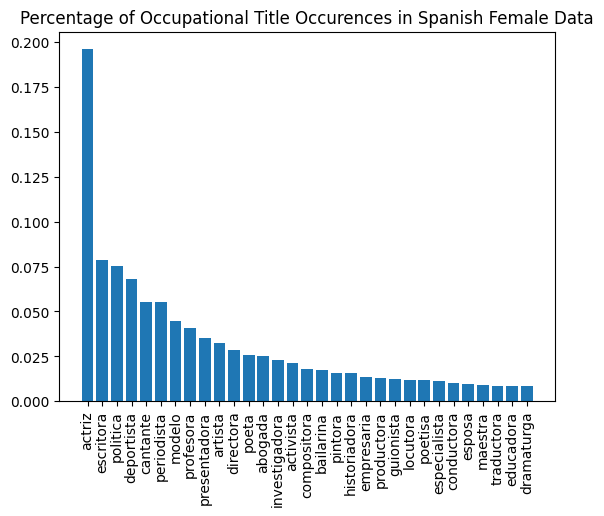

In [45]:
make_plot(female_occ_counts)

{'politico': 1468, 'futbolista': 730, 'escritor': 644, 'abogado': 552, 'periodista': 514, 'actor': 427, 'profesor': 345, 'exfutbolista': 321, 'director': 316, 'poeta': 313, 'botanico': 284, 'deportista': 260, 'empresario': 246, 'compositor': 240, 'historiador': 236, 'pintor': 219, 'medico': 218, 'ingeniero': 204, 'diplomatico': 182, 'musico': 173, 'cantante': 154, 'productor': 132, 'arquitecto': 125, 'entrenador': 122, 'presidente': 119, 'guionista': 114, 'investigador': 112, 'economista': 108, 'baloncesto': 107, 'critico': 97}
9082.0
[0.16163840563752477, 0.08037877119577186, 0.07090949130147545, 0.06077956397269324, 0.056595463554283194, 0.047016075754239155, 0.037987227482933275, 0.03534463774499009, 0.03479409821625193, 0.03446377449900903]


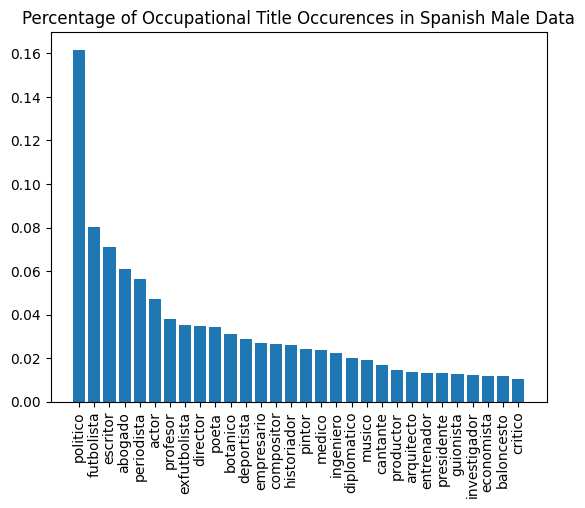

In [54]:
make_plot(male_occ_counts)

In [55]:
female_occ_dict = dict(sorted(female_occ_counts.items(), key=itemgetter(1), reverse=True))

In [56]:
print(female_occ_dict['presidente'])
print(female_occ_dict['presidenta'])

69
47
